In [22]:
# Data manipulation
import pandas as pd , numpy as np , requests
from statistics import mode

# Data viz
import matplotlib.pyplot as plt , seaborn as sns
import plotly.graph_objects as go , plotly.express as px
from tqdm import tqdm

# Data engineering
import boto3
import mysql.connector
from io import BytesIO

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##### Constants ##### 
liste_city = ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Chateau du Haut Koenigsbourg",
"Colmar",
"Eguisheim",
"Besancon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]

# Api's
api_gps = 'https://nominatim.org/'
api_weather = 'https://openweathermap.org/api/one-call-api'
api_weather_key = open("C:\\Users\\lucas\\OneDrive\\Bureau\\Credentials\\Credential_weather_api.txt" , 'r').readlines()[0]


# With a specific user for more safety
creds_s3_user = pd.read_csv("C:\\Users\\lucas\\OneDrive\\Bureau\\Credentials\\credentials_s3_user.csv")
aws_access_key_id = creds_s3_user['Access Key Id'].values[0]
aws_secret_access_key = creds_s3_user['Secret Access Key'].values[0]

# Credentials RDS
USERNAME = 'postgres' # All of this is in the 'Properties' part in pgadmin
PASSWORD = open("C:\\Users\\lucas\\OneDrive\\Bureau\\Credentials\\mdp_rds.txt").readlines()[0]
HOSTNAME = 'database-1.ci5gyznqcmqv.us-east-1.rds.amazonaws.com'
DBNAME = 'postgres' # Mandatory apparently , instead of the name I chose

# Connect to my session
s3 = boto3.client('s3' , aws_access_key_id=aws_access_key_id , aws_secret_access_key=aws_secret_access_key)
bucket_name = 'kayakprojectlucas'

## Get GPS data
Use https://nominatim.org/ to get the gps coordinates of all the cities (no subscription required) Documentation : https://nominatim.org/release-docs/develop/api/Search/

In [3]:
def get_coordinates(address):
    '''Get coordinates from an adress / city using the nominatim.openstreetmap.org api'''
    
    url = 'https://nominatim.openstreetmap.org/search'
    params = {'q': address, 'format': 'jsonv2'}
    response = requests.get(url, params=params).json()
    if len(response) > 0:
        try:
            lat = response[0]['lat']
            lon = response[0]['lon']
            return (float(lat), float(lon))
        except:
            return None
    else:
        return None
    

lat , long = [] , []    
for city in tqdm(liste_city):

    tuple_latlong = get_coordinates(address=city)
    lat.append(tuple_latlong[0])
    long.append(tuple_latlong[1])


df = pd.DataFrame({'City' : liste_city , 'Lat' : lat , 'Long' : long})
df.head()

100%|██████████| 35/35 [00:17<00:00,  2.04it/s]


,City,Lat,Long
0,Mont Saint Michel,48.635954,-1.511460
1,St Malo,48.649518,-2.026041
2,Bayeux,49.276462,-0.702474
3,Le Havre,49.493898,0.107973
4,Rouen,49.440459,1.093966


## Get weather data
Use https://openweathermap.org/appid (you have to subscribe to get a free apikey) and https://openweathermap.org/api/one-call-api to get some information about the weather for the 35 cities and put it in a DataFrame

In [4]:
mean_temps , mean_prob , most_freq_weather = [] , [] , []
for i in tqdm(range(len(df))):
    
    lat = df.iloc[i]['Lat']
    long = df.iloc[i]['Long']

    url = f'https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={long}&exclude=current,minutely,hourly,alerts&units=metric&appid={api_weather_key}'
    response = requests.get(url).json()
    
    temps , prob , weather = [] , [] , []
    for j in range(len(response['daily'])):
        weather.append(response['daily'][j]['weather'][0]['main']) # Main meteo
        prob.append(response['daily'][j]['pop'] * 10) # Probality of precipitation
        temps.append(response['daily'][j]['feels_like']['day']) # Global temperature of the day

    mean_temps.append(np.mean(temps))
    mean_prob.append(np.mean(prob))
    most_freq_weather.append(mode(weather))
    

score = np.array(mean_temps) - np.array(mean_prob) # The KPI here is temperature_of_the_day - (prob_rain * 10) , and the weather has to not be rain
assert len(mean_prob) == len(mean_temps) == len(most_freq_weather) == len(score)

df['score_7_days'] = score 
df['mean_temperature_7_days'] = mean_temps
df['most_freq_weather_7_days'] = most_freq_weather
df['mean_prob_of_rain_7_days'] = np.array(mean_prob) / 10


df = df.sort_values(by='score_7_days' , ascending=False).reset_index(drop=True)
df_bestdest = df[df['most_freq_weather_7_days'] != 'Rain']
df.to_csv('df_with_weather.csv')
df_bestdest.to_csv('df_best_destination.csv')
df.head()

,City,Lat,Long,score_7_days,mean_temperature_7_days,most_freq_weather_7_days,mean_prob_of_rain_7_days
0,Nimes,43.837425,4.360069,15.93875,17.87625,Clouds,0.19375
1,Bormes les Mimosas,43.150697,6.341928,15.52125,15.98375,Clouds,0.04625
2,Uzes,44.012128,4.419672,15.26125,17.14875,Clouds,0.18875
3,Avignon,43.949249,4.805901,14.87250,17.27250,Clouds,0.24000
4,Aigues Mortes,43.565823,4.191284,14.64875,16.61125,Clouds,0.19625


## Find the nicest weather
Determine the list of cities where the weather will be the nicest within the next 7 days For example, you can use the values of daily.pop and daily.rain to compute the expected volume of rain within the next 7 days... But it's only an example, actually you can have different opinions on a what a nice weather would be like 😎 Maybe the most important criterion for you is the temperature or humidity, so feel free to change the rules !

#### Save all the results in a .csv file
Save all the results in a .csv file, you will use it later 😉 You can save all the informations that seem important to you ! Don't forget to save the name of the cities, and also to create a column containing a unique identifier (id) of each city (this is important for what's next in the project)

#### Use plotly to display the best destinations on a map 

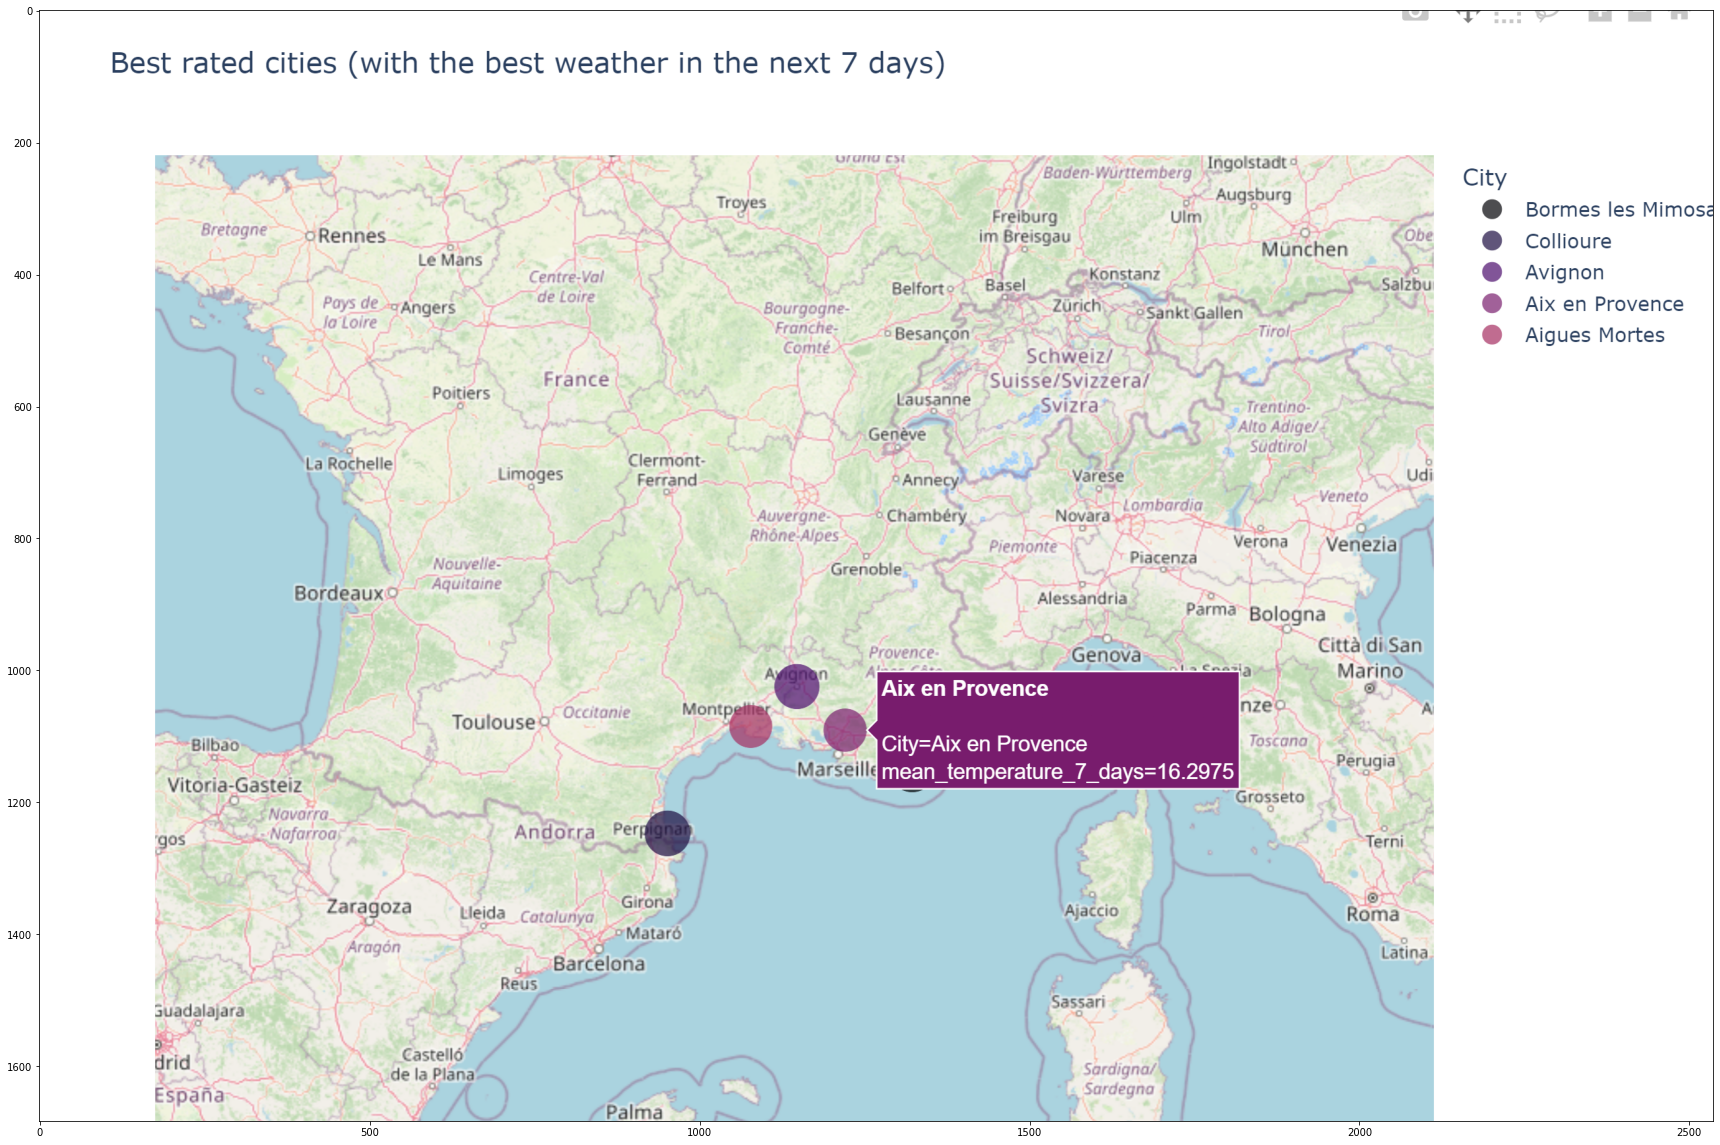

In [36]:
fig = px.scatter_mapbox(df_bestdest.head(), lat="Lat", lon="Long", hover_name = 'City', zoom = 5,
                        hover_data={
        'Lat': False,
        'Long': False,
        'score_7_days': False,
        'City': True,
        'mean_temperature_7_days': True,
        }, 
                        color = 'City', color_discrete_sequence = px.colors.sequential.Inferno, template='plotly', size='score_7_days',
                        mapbox_style='open-street-map',width = 1050, height = 900,
                        title='Best rated cities (with the best weather in the next 7 days)')
# fig.show()

plt.figure(figsize=(30,30)) # For github
im = plt.imread('Example_output_cities.png')
plt.imshow(im)

## Scrape Booking.com
Since BookingHoldings doesn't have aggregated databases, it will be much faster to scrape data directly from booking.com

You can scrap as many information as you want, but we suggest that you get at least:

- hotel name,
- Url to its booking.com page,
- Its coordinates: latitude and longitude
- Score given by the website users
- Text description of the hotel
- Create your data lake using S3
- Once you managed to build your dataset, you should store into S3 as a csv file.

In [6]:
df_scraped = pd.read_csv('Scraped_df.csv' , index_col='Unnamed: 0')

lats , longs = [] , []
for adress in tqdm(list(df_scraped['Adress'])):
        try:
            lat , long = get_coordinates(adress)
            lats.append(lat)
            longs.append(long)

        except TypeError:
            lats.append(np.nan)
            longs.append(np.nan)

assert len(lats) == len(longs) == len(df_scraped)

df_scraped['Lat'] = lats 
df_scraped['Long'] = longs

df_scraped.to_csv('df_scraped_with_lat_long.csv')

100%|██████████| 819/819 [06:51<00:00,  1.99it/s]


## Send data to my data lake & ETL

Once you uploaded your data onto S3, it will be better for the next data analysis team to extract clean data directly from a Data Warehouse. Therefore, create a SQL Database using AWS RDS, extract your data from S3 and store it in your newly created DB.

In [25]:
# Merge all the informations
df_scp_with_lat_long = pd.read_csv('df_scraped_with_lat_long.csv' , index_col='Unnamed: 0')
df_with_weather = pd.read_csv('df_with_weather.csv' , index_col='Unnamed: 0')
merged = df_scp_with_lat_long.merge(df_with_weather.drop(['Lat' , 'Long'] , axis=1) , how='left' , on='City').sort_values(by='score_7_days' , ascending=False)
merged.to_csv('Full_df.csv' , index=False)


# Send the CSV files
s3.upload_file('Full_df.csv', bucket_name, 'Full_df.csv')

# Simulate that I get the data back from s3
response = s3.get_object(Bucket=bucket_name , Key='Full_df.csv')
data = response['Body'].read()
df_s3 = pd.read_csv(BytesIO(data))


# Fake send it to a rds database 
if 1 + 1 == 3:

    import sqlalchemy
    from sqlalchemy import create_engine, text
    from sqlalchemy.ext.declarative import declarative_base
    from sqlalchemy import String , Integer , Column , Float
    from sqlalchemy.orm import sessionmaker
    from sqlalchemy.sql import text

    # Initiate the engine
    engine = create_engine(url=f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOSTNAME}/{DBNAME}", echo=True)
    Base = declarative_base()

    # Create the class to iteratively add the rows , using sqlalchemy
    class Hotel(Base):
        __tablename__ = 'hotel_kayak'

        id = Column(Integer , primary_key=True)
        Name = Column(String , nullable=True)
        City = Column(String , nullable=True)
        Rating = Column(Float , nullable=True)
        Loc = Column(String , nullable=True)
        Description = Column(String , nullable=True)
        Adress = Column(String , nullable=True)
        Link = Column(String , nullable=True)
        Lat = Column(Float , nullable=True)
        Long = Column(Float , nullable=True)
        score_7_days = Column(Float , nullable=True)
        mean_temperature_7_days = Column(Float , nullable=True)
        most_freq_weather_7_days = Column(String , nullable=True)
        mean_prob_of_rain_7_days = Column(Float , nullable=True)


        def __repr__(self) -> str:
            return super().__repr__()


    # Instantiate a session object
    Session = sessionmaker(bind=engine)
    session = Session()

    for i in tqdm(range(len(df))):
        row = df.iloc[i] # Subset row by row

        # Add data to the rds database
        session.add(Hotel(Name=row['Name']) , City=row['City'] , Rating=row['Rating'] , 
                          Loc=row['Loc'] , Description=row['Description'] , Adress=row['Adress'] ,
                          Link=row['Link'] , Lat=row['Lat'] , Long=row['Long'] ,score_7_days=row['score_7_days'] ,
                          mean_temperature_7_days=row['mean_temperature_7_days'] , most_freq_weather_7_days=row['most_freq_weather_7_days'])

## Map of the 20 best destinations

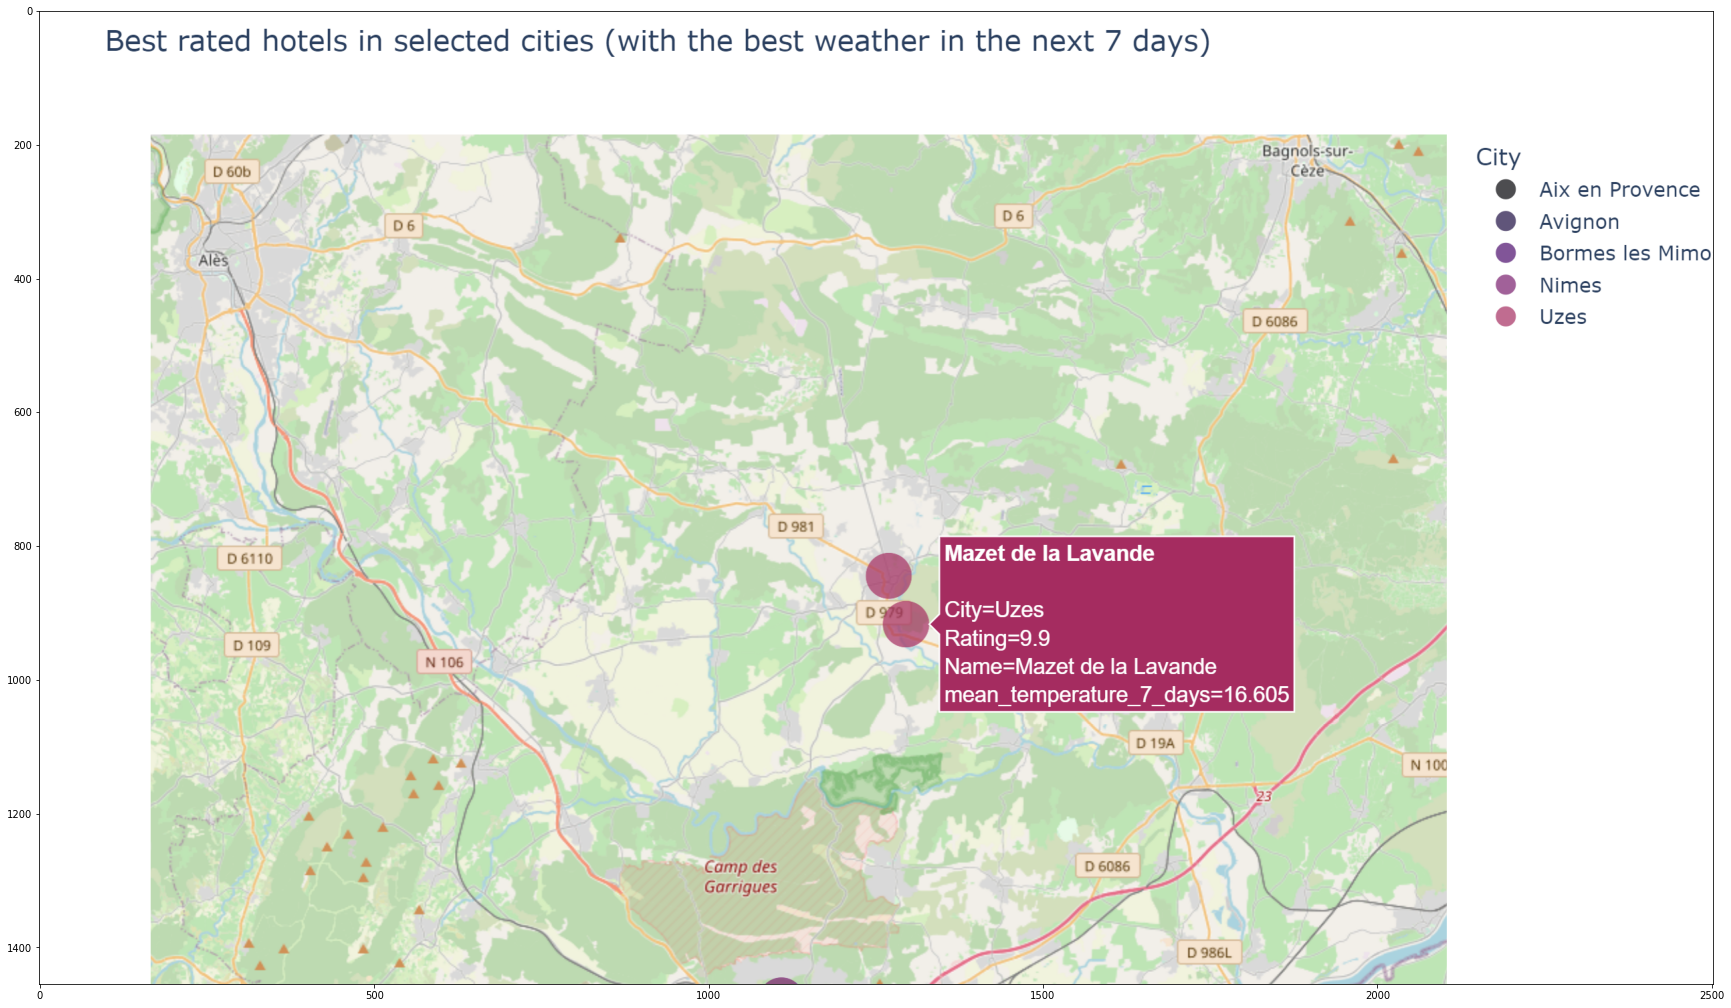

In [35]:
# Get the best destination in the best cities
to_plot = merged[merged['City'].isin(df_bestdest['City'].head())].groupby('City' , as_index=False).apply(lambda x: x.nlargest(4, 'Rating')).reset_index(drop=True)

# Plot the figure
fig = px.scatter_mapbox(to_plot , lat="Lat", lon="Long", hover_name = 'Name', zoom = 5,
                        hover_data={
        'Lat': False,
        'Long': False,
        'score_7_days':False,
        'Name' : True,
        'City': True,
        'mean_temperature_7_days': True,
        }, 
                        color = 'City', color_discrete_sequence = px.colors.sequential.Inferno, template='plotly', size='Rating',
                        mapbox_style='open-street-map',width = 1050, height = 900,
                        title='Best rated hotels in selected cities (with the best weather in the next 7 days)')

# fig.show()

plt.figure(figsize=(30,30)) # For github
im = plt.imread('Example_output_hotels.png')
plt.imshow(im)
